<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition, datasets
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
path = './data/'
emb_data = pd.read_csv('./data/node2vec_v2_test.csv.gz',compression = 'gzip',sep='\t')
emb_data= emb_data.drop(columns=['Unnamed: 0'])
emb_data.head()
cols = ["is_dorm","is_year","year_diff", "from_high_school",
            "to_high_school", "from_major", "to_major", "is_faculty",
            "is_gender",'label']
emb_data = emb_data.sample(n=200)
X =  emb_data.drop(columns=cols).values
y = emb_data['label'].values


,is_dorm,is_year,year_diff,from_high_school,to_high_school,from_major,to_major,is_faculty,is_gender,d0,...,d59,d6,d60,d61,d62,d63,d7,d8,d9,label
0,0,1,0.000000,9741,17636,85,108,1,0,10.642805,...,0.888451,4.503231,0.006351,4.270055,0.025825,-0.171268,2.786140,2.104359,9.533156,1
1,0,0,3.000000,15890,20833,269,293,0,0,-1.099555,...,-0.104149,-2.809527,0.134791,-0.240302,0.728153,1.220623,0.116263,-0.000078,-0.559821,1
2,0,0,2.047161,26488,54927,293,294,0,0,0.688441,...,1.833166,0.678663,-0.789518,-1.177988,-0.341774,-0.033410,1.500471,0.035546,0.978662,0
3,0,1,0.000000,3638,19157,69,85,1,0,1.279752,...,1.178428,-0.489089,1.259993,-1.307781,-1.529061,0.087388,1.313743,-0.202306,-3.085782,0
4,0,0,2.176700,0,18366,0,217,1,1,1.814589,...,0.435346,0.174412,0.387424,-0.604271,0.199949,-0.481228,0.349823,1.335309,0.196309,0


In [3]:
X = StandardScaler().fit_transform(X)
X.shape

(200, 64)

In [4]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(
    data=principalComponents,
    columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.Series(emb_data['label'].values)], axis = 1,ignore_index=True)


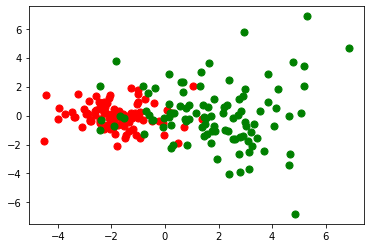

In [5]:
colors = ['r', 'g']
for i, color in enumerate(colors):
    indicesToKeep = finalDf[2] == i
    plt.scatter(finalDf.loc[indicesToKeep, 0],
               finalDf.loc[indicesToKeep, 1],
               c=color,
               s=50)


(200, 64)
(200, 1)


Text(0.5, 0, 'Number of samples')

Text(0, 0.5, 'LDA Component')

Text(0.5, 1.0, 'Embedding dataset (samples = 200)')

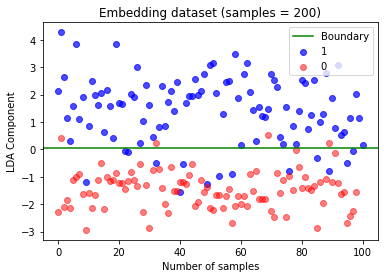

In [6]:
print(X.shape)
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit(X, y).transform(X)
print(X_lda.shape)
ones = y==1
zeros = y==0

plt.scatter(x=list(range(X_lda[ones].shape[0])),y=X_lda[ones],c='b',alpha=0.7,label='1')
plt.scatter(x=list(range(X_lda[zeros].shape[0])),y=X_lda[zeros],c='r',alpha=0.5,label='0')
plt.axhline(lda.intercept_,color='green',label='Boundary')
plt.xlabel("Number of samples")
plt.ylabel("LDA Component")
plt.legend(loc='best')
plt.title('Embedding dataset (samples = 200)')
plt.savefig('emblda')
plt.show()

In [7]:
print("1:",sum(X_lda[ones]> lda.intercept_),"0:",sum(X_lda[zeros]< lda.intercept_))
print ("accuracy:", (sum(X_lda[ones]> lda.intercept_) + sum(X_lda[zeros]<lda.intercept_))/200)

1: [87] 0: [95]
accuracy: [0.91]


[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 3.622608
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.375824
[t-SNE] KL divergence after 1000 iterations: 0.539581


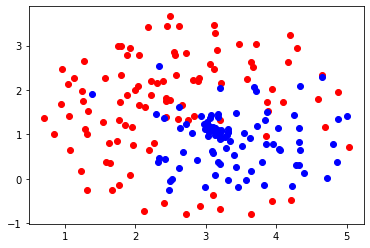

In [8]:

tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=1000)
Xtsne = tsne.fit_transform(X)
plt.scatter(Xtsne[ones][:,0],Xtsne[ones][:,1],color='red')
plt.scatter(Xtsne[zeros][:,0],Xtsne[zeros][:,1],color='blue')
plt.show()

(-0.2937830686569214,
 6.026216931343084,
 -1.7932778000831604,
 4.646722199916845)

Text(0.5, 1.0, 'Perceptron')

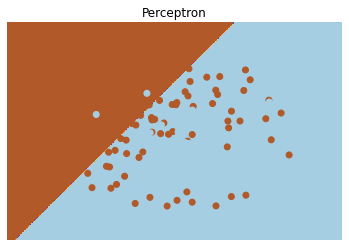

In [9]:
from sklearn.linear_model import Perceptron
import matplotlib.pyplot as plt

h = .02  # step size in the mesh


# we create an instance of SVM and fit our data. We do not scale our
# data since we want to plot the support vectors

clf = Perceptron().fit(Xtsne, y)

# create a mesh to plot in
x_min, x_max = Xtsne[:, 0].min() - 1, Xtsne[:, 0].max() + 1
y_min, y_max = Xtsne[:, 1].min() - 1, Xtsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
fig, ax = plt.subplots()
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)
ax.axis('off')

# Plot also the training points
ax.scatter(Xtsne[:, 0], Xtsne[:, 1], c=y, cmap=plt.cm.Paired)

ax.set_title('Perceptron')

In [10]:
path = './data/'
top_data = pd.read_csv('./data/topological_test.data', sep='\t')
top_data.head()

top_data = top_data.sample(n=200)
X = top_data.drop(columns=['label']).values
y = top_data['label'].values

X = StandardScaler().fit_transform(X)
X.shape

,preferential,jaccard,adamic adar,resource allocation,is_dorm,is_year,year_diff,from_high_school,to_high_school,from_major,to_major,is_faculty,is_gender,label
0,208.0,0.000000,0.000000,0.0,0.0,0.0,6.000000,50058.0,50313.0,0.0,23.0,0.0,0.0,0.0
1,10804.0,0.127551,168.955164,3092.0,0.0,0.0,1.000000,22057.0,22152.0,0.0,247.0,1.0,1.0,1.0
2,6314.0,0.042781,55.959889,1287.0,0.0,0.0,2.000000,10187.0,23271.0,131.0,160.0,0.0,0.0,0.0
3,56.0,0.000000,0.000000,0.0,0.0,0.0,2.196375,0.0,0.0,0.0,40.0,0.0,0.0,0.0
4,1428.0,0.000000,0.000000,0.0,0.0,0.0,3.000000,50334.0,51382.0,0.0,61.0,1.0,0.0,0.0


(200, 13)

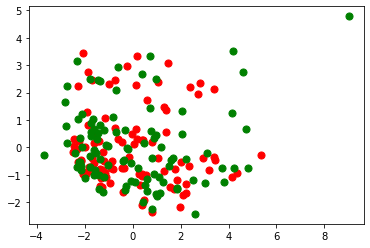

In [11]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(
    data=principalComponents,
    columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.Series(emb_data['label'].values)], axis = 1,ignore_index=True)

colors = ['r', 'g']
for i, color in enumerate(colors):
    indicesToKeep = finalDf[2] == i
    plt.scatter(finalDf.loc[indicesToKeep, 0],
               finalDf.loc[indicesToKeep, 1],
               c=color,
               s=50)

(200, 13)
(200, 1)


Text(0.5, 0, 'Number of samples')

Text(0, 0.5, 'LDA Component')

Text(0.5, 1.0, 'Topological dataset (samples = 200)')

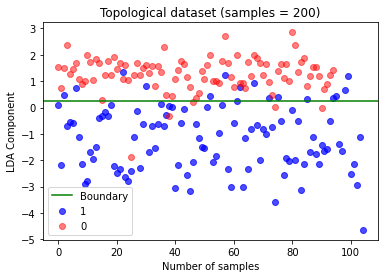

In [12]:
print(X.shape)
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit(X, y).transform(X)
print(X_lda.shape)
ones = y==1
zeros = y==0
plt.scatter(x=list(range(X_lda[ones].shape[0])),y=X_lda[ones],c='b',alpha=0.7,label='1')
plt.scatter(x=list(range(X_lda[zeros].shape[0])),y=X_lda[zeros],c='r',alpha=0.5,label='0')
plt.axhline(lda.intercept_,color='green',label='Boundary')
plt.xlabel("Number of samples")
plt.ylabel("LDA Component")
plt.legend(loc='best')
plt.title('Topological dataset (samples = 200)')
plt.savefig('toplda')
plt.show()

In [16]:
print("1:",sum(X_lda[ones]< lda.intercept_),"0:",sum(X_lda[zeros]>lda.intercept_))
print ("accuracy:", (sum(X_lda[ones]< lda.intercept_) + sum(X_lda[zeros]>lda.intercept_))/200)

1: [89] 0: [90]
accuracy: [0.895]


[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 2.034908
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.108913
[t-SNE] KL divergence after 1000 iterations: 0.344671


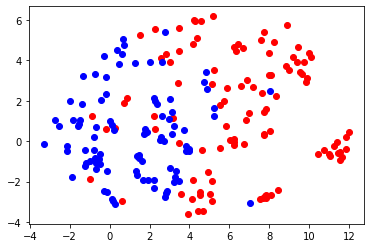

In [14]:
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=1000)
Xtsne = tsne.fit_transform(X)
plt.scatter(Xtsne[ones][:,0],Xtsne[ones][:,1],color='red')
plt.scatter(Xtsne[zeros][:,0],Xtsne[zeros][:,1],color='blue')
plt.show()

In [15]:
X.shape

(200, 13)